In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
import skimage as sk
from scipy import misc

import cv2
from pylab import *
import torch
import torchvision
from torch import nn
from pathlib import Path
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import models
from torch import optim
from torch.utils.data import Dataset, DataLoader

import lovasz_losses as L
import time
from tqdm import tqdm_notebook as tqdm

In [2]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)

In [3]:
work_path = "/home/kaichou/ssd/pa_segface"

In [4]:
train_img_path = work_path + "/train"
train_mask_path = work_path + "/train_mask"
test_path = work_path + "/test"

In [5]:
train_amount = 1491
test_amount = 2177

def upsample(img, mask, arg = 0):
    
    img_stack_1 = np.zeros((320, 136, 3))
    img_stack_2 = np.zeros((96, 512, 3))
    mask_stack_1 = np.zeros((320, 136))
    mask_stack_2 = np.zeros((96, 512))
    
    img = np.hstack((img_stack_1, img))
    img = np.hstack((img, img_stack_1))
    img = np.vstack((img_stack_2, img))
    img = np.vstack((img, img_stack_2))
    img = img.astype(uint8)
    if arg != 0:
        return img
    
    mask = np.hstack((mask_stack_1, mask))
    mask = np.hstack((mask, mask_stack_1))
    mask = np.vstack((mask_stack_2, mask))
    mask = np.vstack((mask, mask_stack_2))
    
    mask = mask.astype(uint8)
    
    return img, mask

def downsample(mask):
    
    mask = np.delete(mask, slice(0, 96), 0)
    mask = np.delete(mask, slice(511- 96 * 2, 511 - 96), 0)
    mask = np.delete(mask, slice(0, 136), 1)
    mask = np.delete(mask, slice(511 - 136 * 2, 511 - 136), 1)
    
    return mask

In [6]:
img_size_target = 256
def upsample(img):
    return cv2.resize(img, (img_size_target, img_size_target))
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
img_x = 240
img_y = 320
def downsample(img):
    return cv2.resize(img, (img_x, img_y))
    #return img[:img_size_ori, :img_size_ori]

In [7]:
train_x = [f"{i}" for i in range(1, train_amount + 1)]
train_y = [f"{i}" for i in range(1, train_amount + 1)]

In [8]:
train_x = np.array(train_x)
train_y = np.array(train_y)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.2, random_state = 43)

In [10]:
def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

In [11]:
img1 = sk.io.imread(os.path.join(train_img_path, "1.jpg"))
mask1 = sk.io.imread(os.path.join(train_mask_path, "1.png"))

In [12]:
np.shape(np.squeeze(np.expand_dims(mask1, 2)))

(320, 240)

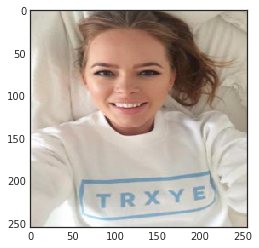

In [13]:
plt.imshow(cv2.resize(img1, (256, 256)))

In [14]:
pr = torch.from_numpy(np.expand_dims(mask1, 2))

In [15]:
torch.cuda.is_available()

True

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x




class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder

        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out
    
def albunet(pretrained = False, **kwargs):

    model = AlbuNet(pretrained = pretrained)

    return model


In [18]:
def get_model():
    model = albunet(pretrained=True)
    model.train()
    return model.to(device)

In [19]:
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])
def chw_to_hwc(img):
    return np.transpose(img, axes=[1, 2, 0])

In [20]:
class PeopleDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(os.path.join(train_img_path, f"{ID}.jpg"))
        y = plt.imread(os.path.join(train_mask_path, f"{ID}.png"))
        
        x = upsample(x)
        y = upsample(y)
        
        augmentatioins = strong_aug(p=0.7)
        augmented = augmentatioins(image = x, mask = y)
        x = augmented["image"]
        y = augmented["mask"]
        
        y = np.expand_dims(y, axis = 2)
        
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        y = torch.from_numpy(y)
        y = hwc_to_chw(y.float())
        
        return x, y

In [21]:
train_dataset = PeopleDataset(x_train)

In [22]:
valid_dataset = PeopleDataset(x_val)

In [64]:
model = get_model()
model = model.cuda()

In [24]:
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

def eval_net(net, dataset_loader, lenin):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    tot = 0
    
    criterion = nn.BCEWithLogitsLoss()
    
    for x, y in dataset_loader:
        x = x.cuda()
        y = y.cuda()
        
        mask_pred = net(x)
        mask_probs = torch.sigmoid(mask_pred)
        mask_probs_flat = mask_probs.view(-1)
        true_mask_flat = y.view(-1)
        loss = criterion(mask_probs_flat, true_mask_flat)
        
        tot += loss.item()
        
    return tot / lenin

In [25]:
def dice(true, pred):
    true = true.astype(bool)
    pred = pred.astype(bool)

    intersection = (true & pred).sum()
    im_sum = true.sum() + pred.sum()

    return 2.0 * intersection / (im_sum + EPS)


def dice_all(true, pred):
    return np.mean([dice(t, p) for t, p in zip(true, pred)])

In [70]:
def train_model(net, train_dataset, valid_dataset,
                epochs=200, batch_size=32, lr=0.01, save_cp=True, opti = "sgd"):
    if opti == "adam":
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checpoints_last/'
    criterion = nn.BCEWithLogitsLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=250)
    
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, num_workers=4)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, num_workers=4)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        epo_time = time.time()
        scheduler.step()
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = torch.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = criterion(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
        
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation loss: {}'.format(val_dice))
    
        if epoch % 20 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))
            
        epo_time = time.time() - epo_time
        print(f"Epoch time: {epo_time}")

def train_model_lovasz(net, train_dataset, valid_dataset, 
                epochs=200, batch_size=32, lr=0.01, save_cp=True, opti = "adam"):
    if opti == "adam":
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checkpoints_lovasz_next/'
        
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=150)
    
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, num_workers=4)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, num_workers=4)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        epo_time = time.time()
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = F.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = L.lovasz_hinge_flat(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
        
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation loss: {}'.format(val_dice))
    
        if epoch % 20 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))
        epo_time = time.time() - epo_time 
        print(f"Epoch time: {epo_time}")

In [71]:
train_model(model, train_dataset=train_dataset, valid_dataset=valid_dataset, epochs = 601, batch_size=27, lr = 0.01)

Starting epoch 1/601.


/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch finished ! Loss: 0.018030168501122684
Validation loss: 0.01942545783559614
Checkpoint 1 saved !
Epoch time: 36.875168561935425
Starting epoch 2/601.
Epoch finished ! Loss: 0.018014634440609273
Validation loss: 0.01943149574624256
Epoch time: 39.13166785240173
Starting epoch 3/601.
Epoch finished ! Loss: 0.018023368946257855
Validation loss: 0.0193904788797117
Epoch time: 38.83082723617554
Starting epoch 4/601.
Epoch finished ! Loss: 0.018019429939305224
Validation loss: 0.01936029460916551
Epoch time: 39.177939653396606
Starting epoch 5/601.
Epoch finished ! Loss: 0.018024029572738097
Validation loss: 0.019389633151599795
Epoch time: 37.08268427848816
Starting epoch 6/601.
Epoch finished ! Loss: 0.01802528824582196
Validation loss: 0.019429347885890947
Epoch time: 39.06293082237244
Starting epoch 7/601.
Epoch finished ! Loss: 0.018009333502526252
Validation loss: 0.019384288568560493
Epoch time: 39.207634925842285
Starting epoch 8/601.
Epoch finished ! Loss: 0.018016437206092296


Checkpoint 61 saved !
Epoch time: 38.38145613670349
Starting epoch 62/601.
Epoch finished ! Loss: 0.017970313436833005
Validation loss: 0.01939125483650029
Epoch time: 37.9524245262146
Starting epoch 63/601.
Epoch finished ! Loss: 0.017974342050768383
Validation loss: 0.019407899583063794
Epoch time: 37.95438551902771
Starting epoch 64/601.
Epoch finished ! Loss: 0.01798483431839303
Validation loss: 0.019360584758197186
Epoch time: 35.28175377845764
Starting epoch 65/601.
Epoch finished ! Loss: 0.017971772525534533
Validation loss: 0.01938181836469516
Epoch time: 36.094547510147095
Starting epoch 66/601.
Epoch finished ! Loss: 0.017973440405506417
Validation loss: 0.019419629039573033
Epoch time: 35.6171612739563
Starting epoch 67/601.
Epoch finished ! Loss: 0.017967984805371137
Validation loss: 0.01937825544223339
Epoch time: 36.26806092262268
Starting epoch 68/601.
Epoch finished ! Loss: 0.017974123008699223
Validation loss: 0.019385891315530375
Epoch time: 35.93497848510742
Starting

Epoch finished ! Loss: 0.017935349737237764
Validation loss: 0.019338331692992247
Epoch time: 36.036198139190674
Starting epoch 123/601.
Epoch finished ! Loss: 0.0179394686332085
Validation loss: 0.01939561773702054
Epoch time: 35.672553062438965
Starting epoch 124/601.
Epoch finished ! Loss: 0.017937747174061384
Validation loss: 0.01941511573201438
Epoch time: 35.83404278755188
Starting epoch 125/601.
Epoch finished ! Loss: 0.01795737482857384
Validation loss: 0.01934935476468957
Epoch time: 35.59894609451294
Starting epoch 126/601.
Epoch finished ! Loss: 0.01793297200194941
Validation loss: 0.01939264856852018
Epoch time: 35.646960973739624
Starting epoch 127/601.
Epoch finished ! Loss: 0.017943209874749982
Validation loss: 0.0193796634275379
Epoch time: 35.596007347106934
Starting epoch 128/601.
Epoch finished ! Loss: 0.01794695259140642
Validation loss: 0.019319505396495296
Epoch time: 35.42212462425232
Starting epoch 129/601.
Epoch finished ! Loss: 0.01794703407275597
Validation l

Validation loss: 0.01943450976773648
Epoch time: 35.756186962127686
Starting epoch 183/601.
Epoch finished ! Loss: 0.017914096131020744
Validation loss: 0.019339238122155437
Epoch time: 35.558692932128906
Starting epoch 184/601.
Epoch finished ! Loss: 0.01793140085451555
Validation loss: 0.019331303926614616
Epoch time: 35.90655303001404
Starting epoch 185/601.
Epoch finished ! Loss: 0.017913103128639644
Validation loss: 0.01936454318438884
Epoch time: 35.61450409889221
Starting epoch 186/601.
Epoch finished ! Loss: 0.01792599768346588
Validation loss: 0.019367822735604633
Epoch time: 35.861135482788086
Starting epoch 187/601.
Epoch finished ! Loss: 0.017917938780464583
Validation loss: 0.01935786008834839
Epoch time: 35.35361194610596
Starting epoch 188/601.
Epoch finished ! Loss: 0.017947356547885294
Validation loss: 0.019345781974569213
Epoch time: 35.672988414764404
Starting epoch 189/601.
Epoch finished ! Loss: 0.017957176763139314
Validation loss: 0.01935048535914724
Epoch time: 

Validation loss: 0.019308453120515497
Epoch time: 35.56047487258911
Starting epoch 243/601.
Epoch finished ! Loss: 0.01791585324294615
Validation loss: 0.01939298775682481
Epoch time: 35.58384466171265
Starting epoch 244/601.
Epoch finished ! Loss: 0.017923827214329034
Validation loss: 0.01934628781666325
Epoch time: 36.013633728027344
Starting epoch 245/601.
Epoch finished ! Loss: 0.017910072067439956
Validation loss: 0.019354825932844027
Epoch time: 35.753379821777344
Starting epoch 246/601.
Epoch finished ! Loss: 0.017909794670823438
Validation loss: 0.0193515865499758
Epoch time: 35.676616191864014
Starting epoch 247/601.
Epoch finished ! Loss: 0.017913714226260282
Validation loss: 0.019347535028904177
Epoch time: 35.9087655544281
Starting epoch 248/601.
Epoch finished ! Loss: 0.017927739344187232
Validation loss: 0.019276290234913396
Epoch time: 35.825387954711914
Starting epoch 249/601.
Epoch finished ! Loss: 0.01790847284281814
Validation loss: 0.019312094984245937
Epoch time: 3

Epoch finished ! Loss: 0.017894778500667355
Validation loss: 0.01928731300759076
Epoch time: 35.829257011413574
Starting epoch 304/601.
Epoch finished ! Loss: 0.01787747777748428
Validation loss: 0.0192862144082685
Epoch time: 35.575700759887695
Starting epoch 305/601.
Epoch finished ! Loss: 0.017890439187520302
Validation loss: 0.019317469568954262
Epoch time: 35.85679364204407
Starting epoch 306/601.
Epoch finished ! Loss: 0.01788483407573412
Validation loss: 0.01930743814710789
Epoch time: 36.07642078399658
Starting epoch 307/601.
Epoch finished ! Loss: 0.017887974270438187
Validation loss: 0.019290984075603677
Epoch time: 35.386892318725586
Starting epoch 308/601.
Epoch finished ! Loss: 0.0178900423565967
Validation loss: 0.01930808383086852
Epoch time: 35.81986951828003
Starting epoch 309/601.
Epoch finished ! Loss: 0.017892142320239304
Validation loss: 0.019262340355876297
Epoch time: 35.67250418663025
Starting epoch 310/601.
Epoch finished ! Loss: 0.017891268227124373
Validation

Epoch finished ! Loss: 0.0178955368347616
Validation loss: 0.01925507566601935
Epoch time: 35.34130597114563
Starting epoch 364/601.
Epoch finished ! Loss: 0.017904067649537284
Validation loss: 0.019344687860546304
Epoch time: 35.66090106964111
Starting epoch 365/601.
Epoch finished ! Loss: 0.017910029314108344
Validation loss: 0.0192220835980763
Epoch time: 35.38403534889221
Starting epoch 366/601.
Epoch finished ! Loss: 0.01787998582292723
Validation loss: 0.01922082751490998
Epoch time: 35.32824754714966
Starting epoch 367/601.
Epoch finished ! Loss: 0.017882081961271747
Validation loss: 0.019307869832252578
Epoch time: 35.43258619308472
Starting epoch 368/601.
Epoch finished ! Loss: 0.017892564203115118
Validation loss: 0.019335096596076736
Epoch time: 35.846866607666016
Starting epoch 369/601.
Epoch finished ! Loss: 0.017891355483923982
Validation loss: 0.019369060678226892
Epoch time: 35.79099106788635
Starting epoch 370/601.
Epoch finished ! Loss: 0.017882560173537107
Validation

Epoch finished ! Loss: 0.017891800518603933
Validation loss: 0.019309503477951354
Epoch time: 35.79375600814819
Starting epoch 424/601.
Epoch finished ! Loss: 0.017884958235409434
Validation loss: 0.01928933697400683
Epoch time: 35.82093524932861
Starting epoch 425/601.
Epoch finished ! Loss: 0.01786926916281649
Validation loss: 0.019281068573827328
Epoch time: 35.848801612854004
Starting epoch 426/601.
Epoch finished ! Loss: 0.01789814351289064
Validation loss: 0.01930124225425082
Epoch time: 35.64210844039917
Starting epoch 427/601.
Epoch finished ! Loss: 0.01789051591849967
Validation loss: 0.019295003302519934
Epoch time: 35.600921630859375
Starting epoch 428/601.
Epoch finished ! Loss: 0.017885015989910037
Validation loss: 0.019289529044492586
Epoch time: 35.459298849105835
Starting epoch 429/601.
Epoch finished ! Loss: 0.0178835296240829
Validation loss: 0.019326806766133645
Epoch time: 35.632673025131226
Starting epoch 430/601.
Epoch finished ! Loss: 0.01788666991879476
Validati

Validation loss: 0.0192732658473943
Epoch time: 35.312458515167236
Starting epoch 484/601.
Epoch finished ! Loss: 0.017879313070502056
Validation loss: 0.019260291969497068
Epoch time: 35.549683570861816
Starting epoch 485/601.
Epoch finished ! Loss: 0.017879009921878776
Validation loss: 0.01928140666572545
Epoch time: 35.601844787597656
Starting epoch 486/601.
Epoch finished ! Loss: 0.017887457555172428
Validation loss: 0.01930426036235082
Epoch time: 35.70112204551697
Starting epoch 487/601.
Epoch finished ! Loss: 0.017880555017282498
Validation loss: 0.019290274700592195
Epoch time: 35.44837498664856
Starting epoch 488/601.
Epoch finished ! Loss: 0.017879032848665377
Validation loss: 0.019321902340471146
Epoch time: 35.62525773048401
Starting epoch 489/601.
Epoch finished ! Loss: 0.01787257474540864
Validation loss: 0.019300910541445115
Epoch time: 35.58615970611572
Starting epoch 490/601.
Epoch finished ! Loss: 0.01789531351735928
Validation loss: 0.01932258520237977
Epoch time: 35

Validation loss: 0.019312254162536416
Epoch time: 35.72238278388977
Starting epoch 544/601.
Epoch finished ! Loss: 0.017869308090850012
Validation loss: 0.01927061055017554
Epoch time: 35.96407079696655
Starting epoch 545/601.
Epoch finished ! Loss: 0.01789102483315756
Validation loss: 0.01928760913702158
Epoch time: 35.68605065345764
Starting epoch 546/601.
Epoch finished ! Loss: 0.01789787726714307
Validation loss: 0.019301335847497384
Epoch time: 35.40232539176941
Starting epoch 547/601.
Epoch finished ! Loss: 0.017889771510490635
Validation loss: 0.019315120368498227
Epoch time: 35.61035132408142
Starting epoch 548/601.
Epoch finished ! Loss: 0.017878546110735645
Validation loss: 0.01931338974066004
Epoch time: 35.365469455718994
Starting epoch 549/601.
Epoch finished ! Loss: 0.017885565582737826
Validation loss: 0.019343190169254672
Epoch time: 35.68809485435486
Starting epoch 550/601.
Epoch finished ! Loss: 0.017874240400207124
Validation loss: 0.019281329119883252
Epoch time: 35

In [594]:
train_model_lovasz(model, train_dataset=train_dataset, valid_dataset=valid_dataset, epochs=1, batch_size=27, opti="sgd")

Starting epoch 1/1.


/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch finished ! Loss: 0.016547440282450428
Validation loss: 0.010154266570722778
Checkpoint 1 saved !
Epoch time: 34.41143822669983


In [68]:
chekpoint = torch.load("./checpoints_last/CP141.pth")

In [69]:
model.load_state_dict(chekpoint)

# Проверочка

In [31]:
model = model.eval()

In [49]:
tutu = str(1515)

In [50]:
test1 = plt.imread(os.path.join(test_path,f"{tutu}.jpg"))
test1_mk = plt.imread(os.path.join(test_path,f"{tutu}.jpg"))

In [51]:
test1= upsample(test1)

In [52]:
test1 = hwc_to_chw(test1)

In [53]:
test1 = np.expand_dims(test1, axis = 0)

In [54]:
test1 = torch.from_numpy(test1)

In [55]:
test1 = test1.float()

In [56]:
test1 = test1.cuda()

In [57]:
pred_msk = model(test1)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [58]:
pred_msk = torch.sigmoid(pred_msk)

In [59]:
pred_msk = pred_msk.cpu()

In [60]:
pred_msk = chw_to_hwc(pred_msk[0].detach().numpy())

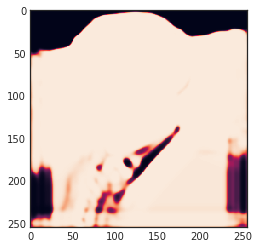

In [61]:
plt.imshow(np.squeeze(pred_msk))

In [62]:
pred_msk = downsample(np.squeeze(pred_msk))

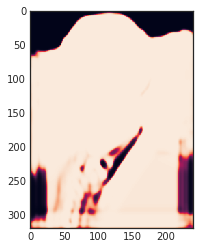

In [63]:
plt.imshow(pred_msk)

In [664]:
pred_msk[pred_msk > 0.65] = 1
pred_msk[pred_msk <= 0.65] = 0

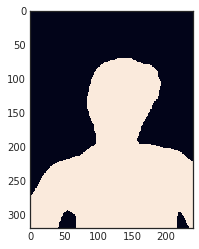

In [665]:
plt.imshow(pred_msk)

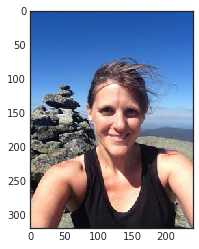

In [666]:
plt.imshow(test1_mk)

# Тест

In [158]:
submission = pd.read_csv("sample_submission.csv")

In [159]:
class PeopleTestDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(os.path.join(test_path, f"{ID}.jpg"))
        
        x = upsample(x)
        
        
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        
        return x

In [160]:
test_dataset = PeopleTestDataset(submission["image"])

In [161]:
test_masks = []

In [162]:
def test_work(net, dataset, batch_size = 7):
    net.eval()
    test_loader = DataLoader(dataset = dataset, batch_size = batch_size)
    for x in tqdm(test_loader):
        x = x.float().cuda()
        mask = net(x)
        mask = F.sigmoid(mask)
        for i in mask.cpu():
            i = i.detach().numpy()
            i = chw_to_hwc(i)
            i = downsample(i)
            i = np.squeeze(i)
            i[i > 0.5] = 1
            i[i <= 0.5] = 0
            test_masks.append(i)

In [190]:
test_work(model, test_dataset)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [164]:
submission = submission.drop("rle_mask", 1)

In [165]:
submission["rle_mask"] = test_masks

In [166]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

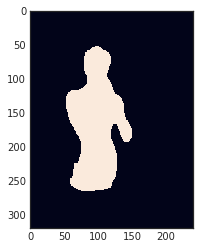

In [192]:
plt.imshow(test_masks[3])

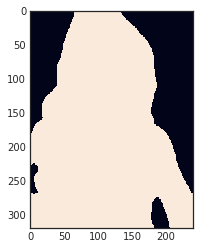

In [167]:
plt.imshow(test_masks[1])

In [168]:
submission.rle_mask = submission.rle_mask.apply(rle_encode)

In [169]:
submission.to_csv("sub.csv", index=False)